In [1]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/Documents/agh/stopien_2/Project-MIDAS`


In [2]:
using MLJ, DataFrames, DataFramesMeta, CairoMakie, UnROOT, LaTeXStrings
CairoMakie.activate!()

### experiment data

#### read `.root` files

In [3]:
f_exp = ROOTFile("data/Data_2018_Xib2XicPi_2018_MD.addVar.wMVA.root")

ROOTFile with 2 entries and 21 streamers.
data/Data_2018_Xib2XicPi_2018_MD.addVar.wMVA.root
└─ mytree (TTree)
   ├─ "Xb_ENDVERTEX_X"
   ├─ "Xb_ENDVERTEX_Y"
   ├─ "Xb_ENDVERTEX_Z"
   ├─ "⋮"
   ├─ "pi_PTo"
   ├─ "pi_Po"
   └─ "BDTG_Xib"


In [4]:
df_exp = LazyTree(f_exp, "mytree", ["Xb_M", "Xc_M", "Xb_TAU", "Xc_TAU"]) |> DataFrame

Row,Xb_M,Xc_TAU,Xb_TAU,Xc_M
,Float64,Float64,Float64,Float64
1,5906.68,0.000815827,0.00167324,2510.3
2,5679.12,0.00138945,0.0026473,2468.57
3,5690.74,-0.000351875,0.000806715,2517.45
4,5945.17,0.000624979,0.000491548,2428.47
5,5646.24,0.00113982,0.00240525,2484.98
6,5561.59,1.11562e-6,0.00129938,2444.5
7,5596.13,0.000933746,0.00228823,2439.99
8,6031.52,0.00241897,0.00160916,2491.02
9,5647.72,-2.46276e-5,0.00108872,2462.74


#### simple function for plotting histograms

In [5]:
set_theme!(merge(theme_dark(), theme_latexfonts()) )

In [6]:
function plot_hist(data; title, xlabel="", bins=80, size=(600,400), yscale = identity)
    f = Figure(;size)

    ax = Axis(
        f[1, 1],
        title = title,
        xlabel = xlabel,
        ylabel = "Entries [-]",
        yscale = yscale
    )

    hist!(
        data,
        bins = 80,
        color = :yellow,
        strokecolor = :black,
        strokewidth = 1
    )

    f
end

function plot_hist(data, filename::AbstractString; title, xlabel="", bins=80, size=(600,400), yscale = identity)
    endswith(filename, r"\.\w+$") || (filename *= ".pdf")

    f = Figure(;size)

    ax = Axis(
        f[1, 1],
        title = title,
        xlabel = xlabel,
        ylabel = "Entries [-]",
        yscale = yscale
    )

    hist!(
        data,
        bins = 80,
        color = :yellow,
        strokecolor = :black,
        strokewidth = 1
    )

    save(filename, f)

    f
end

plot_hist (generic function with 2 methods)

#### plots (precut)

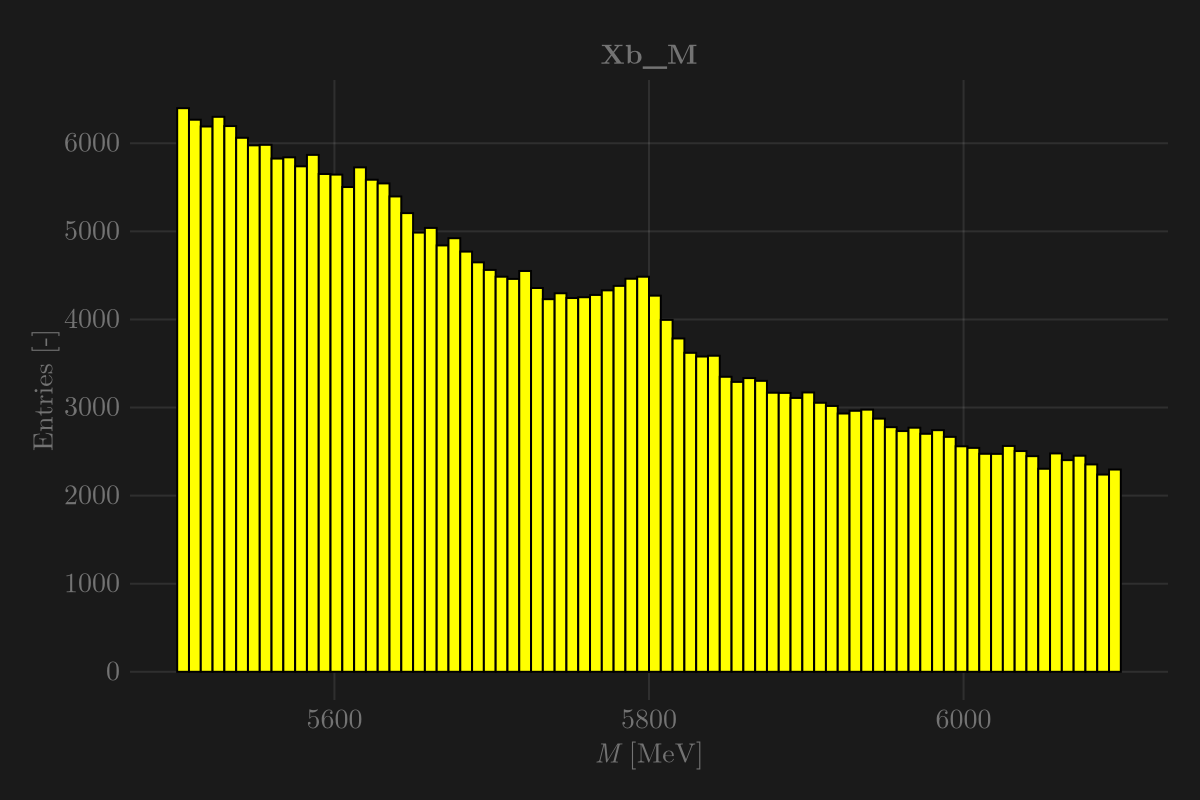

In [7]:
plot_hist(
    df_exp.Xb_M,
    # "figures/exp_Xb_M",
    title = "Xb_M",
    xlabel = L"$M$ [MeV]"
)

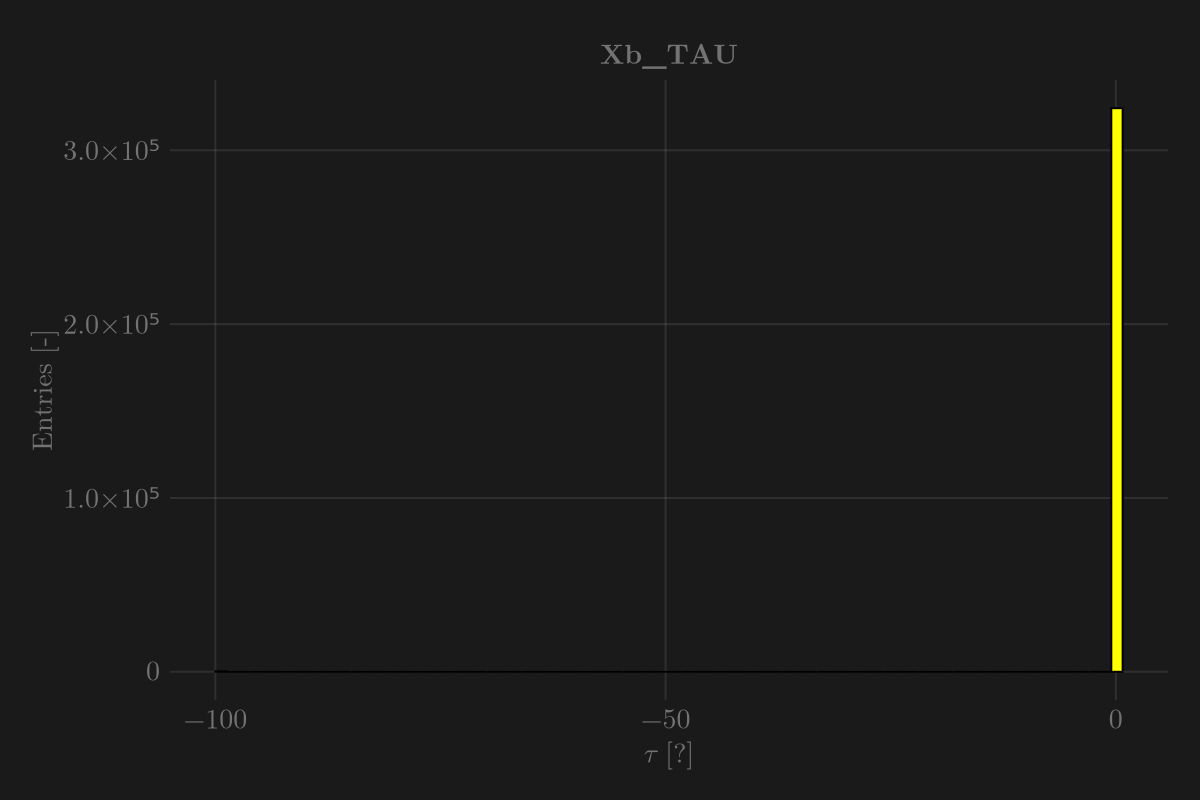

In [8]:
plot_hist(
    df_exp.Xb_TAU,
    title = "Xb_TAU",
    xlabel = L"$\tau$ [?]"
)

In [9]:
minimum(df_exp.Xb_TAU)

-100.0

I suppose that this one bin behaviour is caused by there being values of -100 in the data. From a physics standpoint $\tau$ cannot take on a negative value. I suppose that some values below 0 could be caused by measurement uncertainties, but -100 is almost definitely a value assigned when something wrong happened in the measurement.

In [10]:
@subset df_exp :Xb_TAU .< -1

Row,Xb_M,Xc_TAU,Xb_TAU,Xc_M
,Float64,Float64,Float64,Float64
1,5732.37,0.000141408,-100.0,2485.85
2,6004.97,-1.67852e-5,-100.0,2473.72
3,6012.56,9.35565e-5,-100.0,2477.59
4,5983.83,9.95654e-5,-100.0,2466.84
5,5634.29,3.31048e-5,-100.0,2450.06
6,5896.27,0.000318319,-100.0,2446.98
7,5938.25,0.000673656,-100.0,2435.34
8,5730.31,7.20228e-5,-100.0,2454.82
9,6027.0,-0.00363508,-100.0,2472.96


In [11]:
print("Number of entries with Xb_TAU value below -1:   $(sum(df_exp.Xb_TAU .< -1))
Number of entries with Xb_TAU equal to -100:    $(sum(df_exp.Xb_TAU .== -100))
Number of entries with Xb_TAU below 0:          $(sum(df_exp.Xb_TAU .< 0))\n
ergo: $(sum(df_exp.Xb_TAU .== -100)) weird Xb_TAU values, the $(sum(df_exp.Xb_TAU .< 0) - sum(df_exp.Xb_TAU .== -100)) values below 0 probably due to measurement uncertainty -- okayish
")

Number of entries with Xb_TAU value below -1:   292
Number of entries with Xb_TAU equal to -100:    292
Number of entries with Xb_TAU below 0:          299

ergo: 292 weird Xb_TAU values, the 7 values below 0 probably due to measurement uncertainty -- okayish


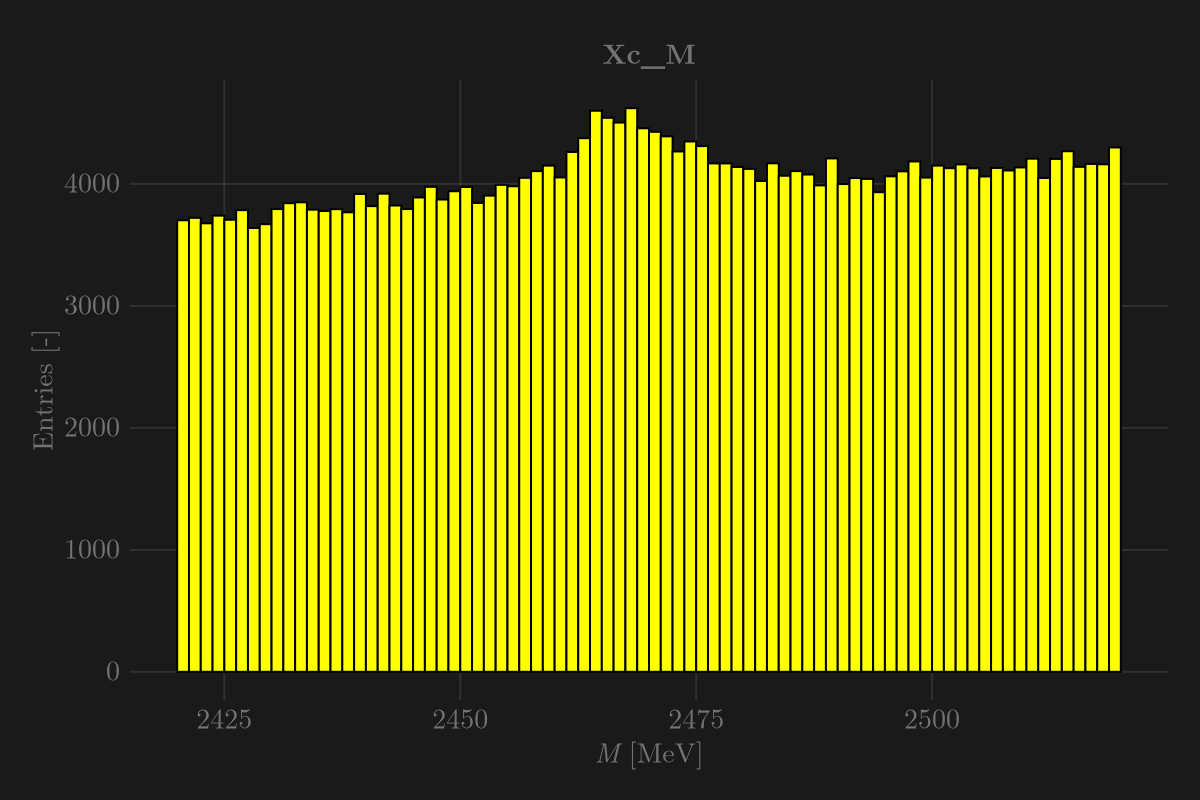

In [12]:
plot_hist(
    df_exp.Xc_M,
    "figures/exp_Xc_M",
    title = "Xc_M",
    xlabel = L"$M$ [MeV]"
)

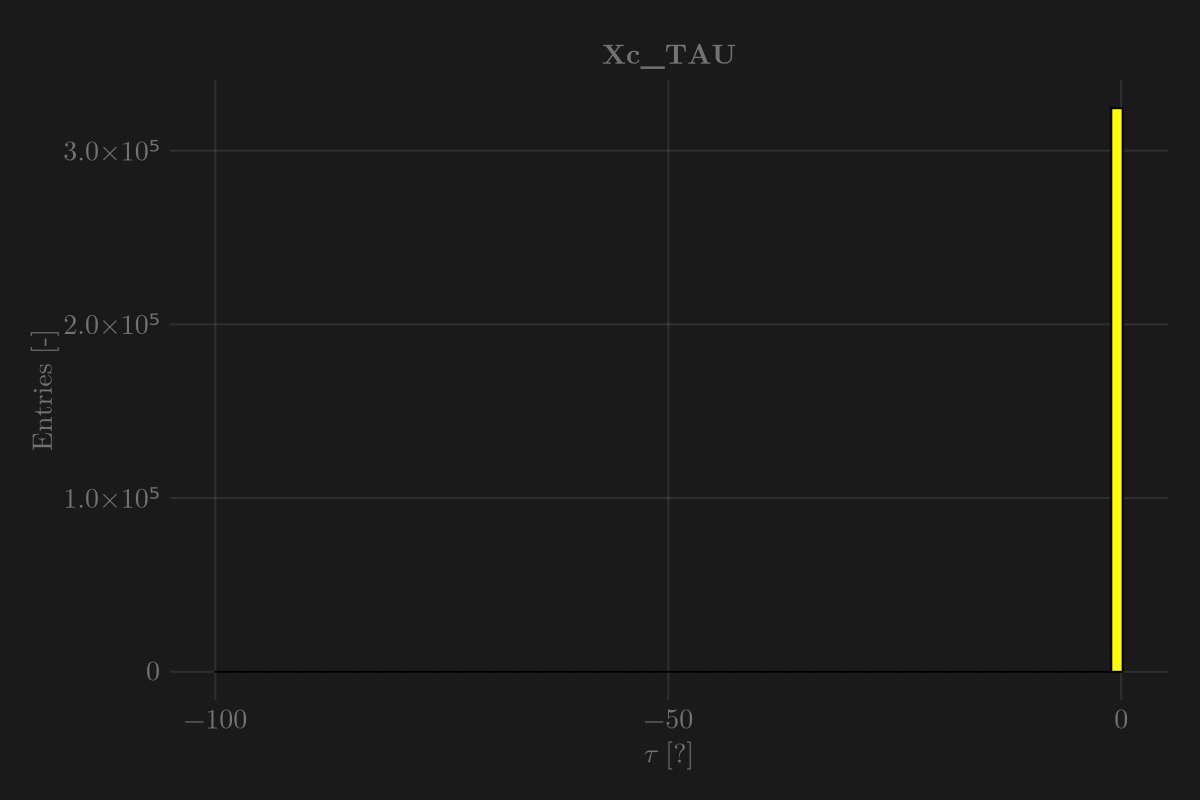

In [13]:
plot_hist(
    df_exp.Xc_TAU,
    title = "Xc_TAU",
    xlabel = L"$\tau$ [?]"
)

In [14]:
minimum(df_exp.Xc_TAU)

-100.0

same behaviour as in Xb_TAU

In [15]:
@subset df_exp :Xc_TAU .< -1

Row,Xb_M,Xc_TAU,Xb_TAU,Xc_M
,Float64,Float64,Float64,Float64
1,6042.8,-100.0,0.00344676,2500.38
2,5605.49,-100.0,0.0127124,2490.04
3,5653.08,-100.0,0.00343243,2518.13
4,5675.85,-100.0,0.00135625,2474.63
5,5575.96,-100.0,0.0162359,2450.55
6,5669.47,-100.0,0.00477073,2512.05
7,5668.97,-100.0,0.00224793,2460.85
8,5623.3,-100.0,0.0126545,2468.96
9,5566.41,-100.0,0.000802103,2466.95


In [16]:
print("Number of entries with Xc_TAU value below -1:   $(sum(df_exp.Xc_TAU .< -1))
Number of entries with Xc_TAU equal to -100:    $(sum(df_exp.Xc_TAU .== -100))
Number of entries with Xc_TAU below 0:          $(sum(df_exp.Xc_TAU .< 0))\n
ergo: $(sum(df_exp.Xc_TAU .== -100)) weird Xc_TAU values, the $(sum(df_exp.Xc_TAU .< 0) - sum(df_exp.Xc_TAU .== -100)) values below 0 probably due to measurement uncertainty -- okayish
a lot more than with Xb_TAU, we even get a measurement below -1 that isn't registered as -100!

Xb_TAU == -100 and Xc_TAU == -100 overlap:
")
@subset df_exp :Xb_TAU .== -100 :Xc_TAU .== -100

Number of entries with Xc_TAU value below -1:   32
Number of entries with Xc_TAU equal to -100:    31
Number of entries with Xc_TAU below 0:          117842

ergo: 31 weird Xc_TAU values, the 117811 values below 0 probably due to measurement uncertainty -- okayish
a lot more than with Xb_TAU, we even get a measurement below -1 that isn't registered as -100!

Xb_TAU == -100 and Xc_TAU == -100 overlap:


Row,Xb_M,Xc_TAU,Xb_TAU,Xc_M
,Float64,Float64,Float64,Float64
1,5555.56,-100.0,-100.0,2515.87


as we can see events in which both Xb_TAU and Xc_TAU are registered as -100 are rather _rare_

#### cut out weird values in the data

We want to cut out rows in which Xb_TAU or Xc_TAU takes on the value of -100:

In [17]:
df_exp_cut = @rsubset df_exp :Xb_TAU != -100 && :Xc_TAU != -100

Row,Xb_M,Xc_TAU,Xb_TAU,Xc_M
,Float64,Float64,Float64,Float64
1,5906.68,0.000815827,0.00167324,2510.3
2,5679.12,0.00138945,0.0026473,2468.57
3,5690.74,-0.000351875,0.000806715,2517.45
4,5945.17,0.000624979,0.000491548,2428.47
5,5646.24,0.00113982,0.00240525,2484.98
6,5561.59,1.11562e-6,0.00129938,2444.5
7,5596.13,0.000933746,0.00228823,2439.99
8,6031.52,0.00241897,0.00160916,2491.02
9,5647.72,-2.46276e-5,0.00108872,2462.74


#### plots (postcut)

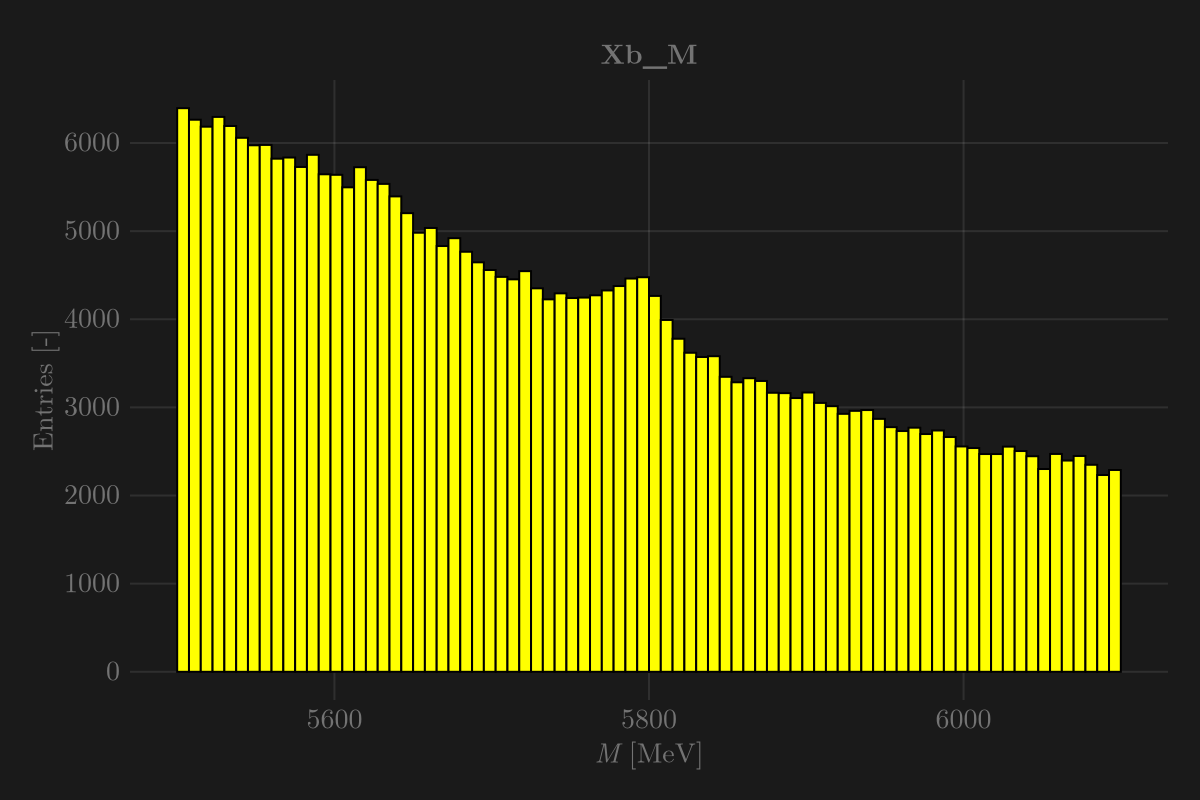

In [18]:
plot_hist(
    df_exp_cut.Xb_M,
    "figures/exp_Xb_M",
    title = "Xb_M",
    xlabel = L"$M$ [MeV]"
)

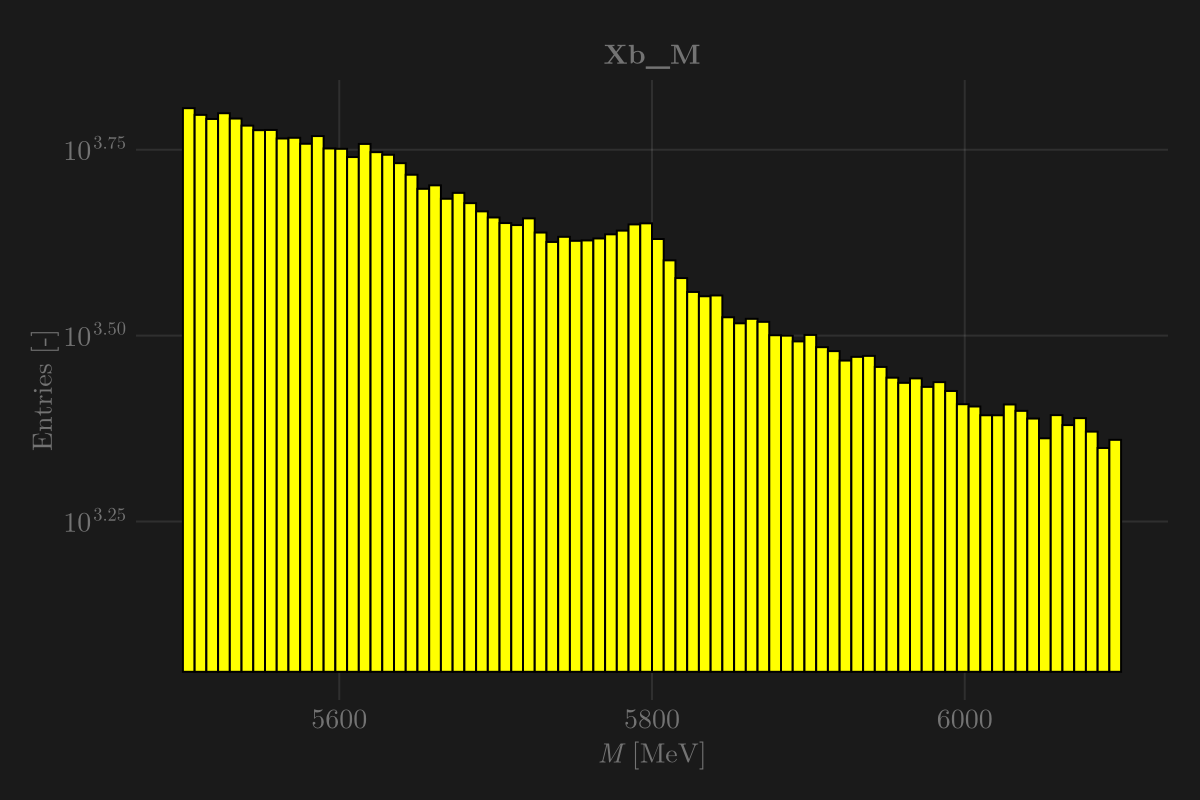

In [19]:
plot_hist(
    df_exp_cut.Xb_M,
    "figures/exp_Xb_M_log10",
    title = "Xb_M",
    xlabel = L"$M$ [MeV]",
    yscale = log10
)

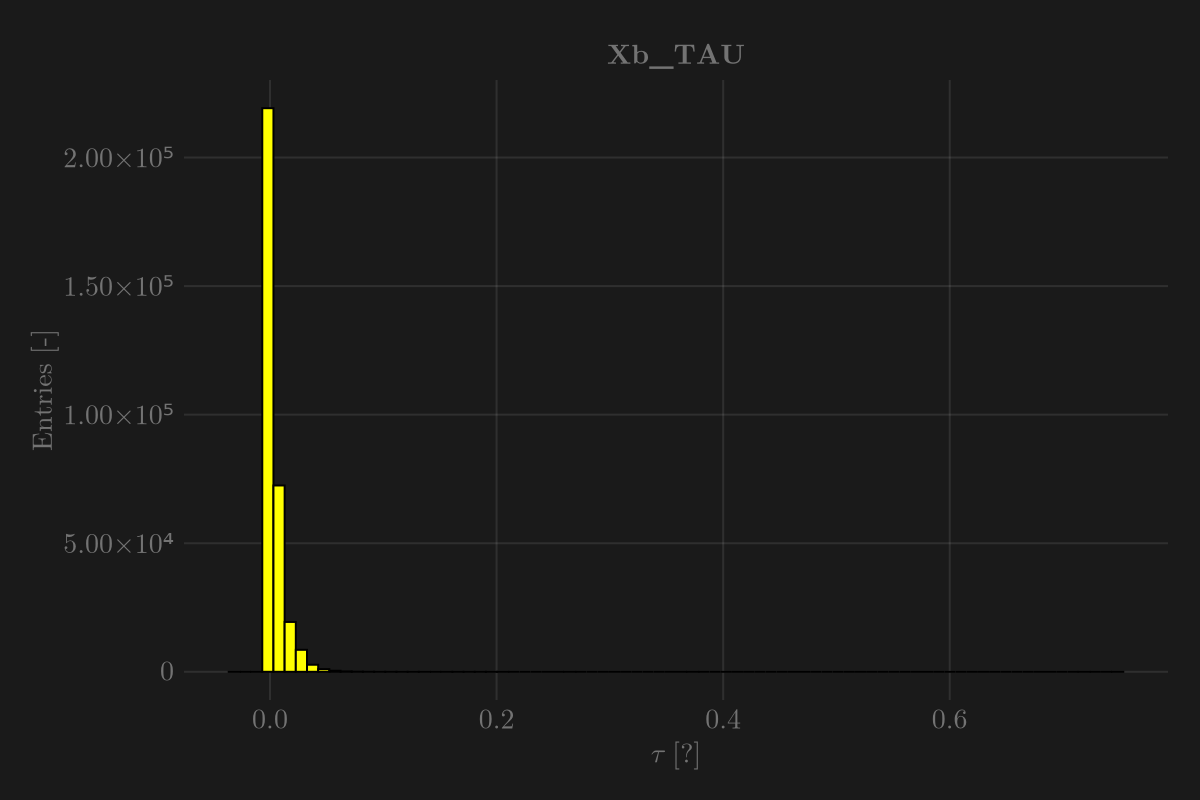

In [20]:
plot_hist(
    df_exp_cut.Xb_TAU,
    "figures/exp_Xb_TAU",
    title = "Xb_TAU",
    xlabel = L"$τ$ [?]"
)

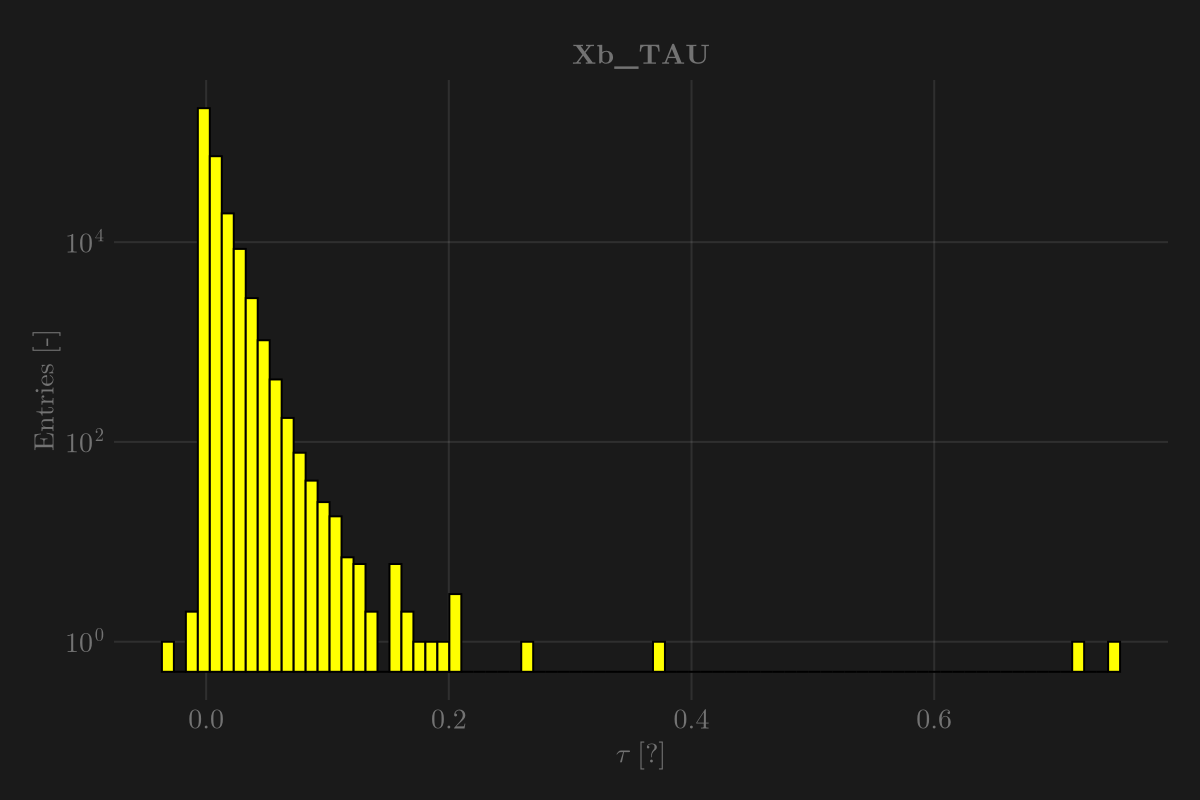

In [21]:
plot_hist(
    df_exp_cut.Xb_TAU,
    "figures/exp_Xb_TAU_log10",
    title = "Xb_TAU",
    xlabel = L"$τ$ [?]",
    yscale = log10
)

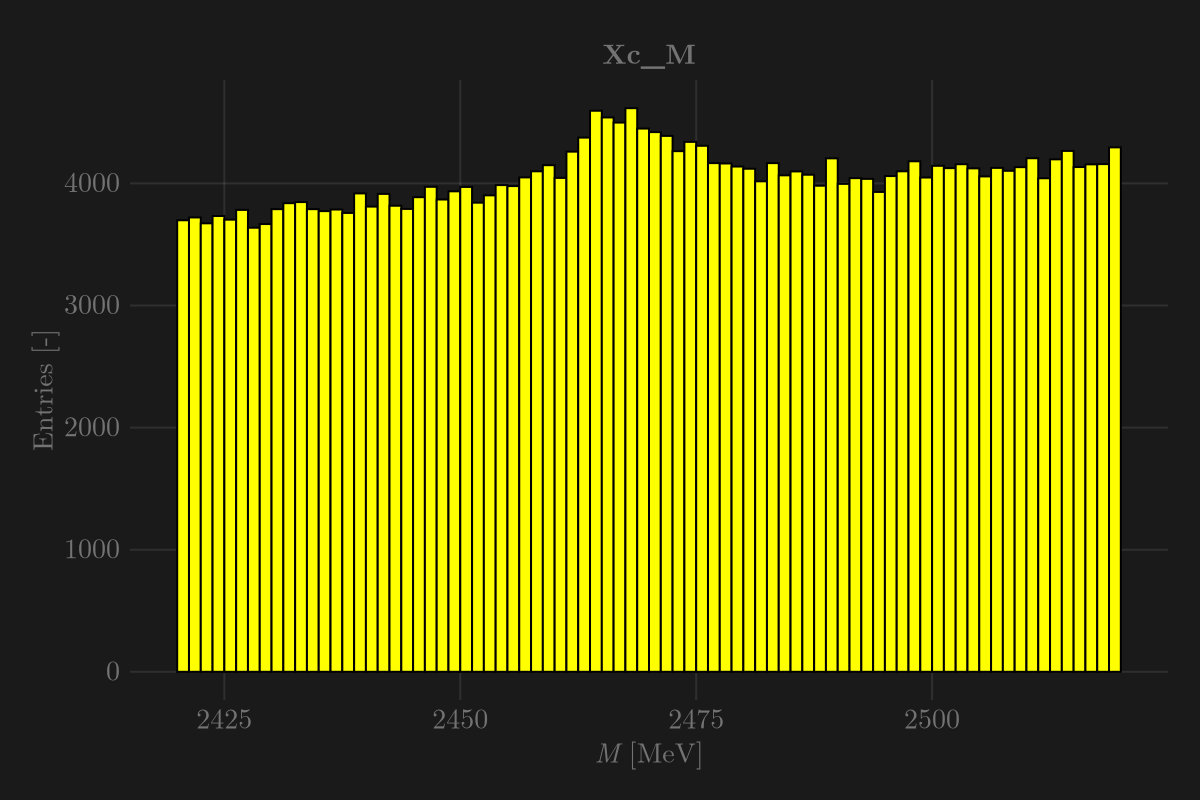

In [22]:
plot_hist(
    df_exp_cut.Xc_M,
    "figures/exp_Xc_M",
    title = "Xc_M",
    xlabel = L"$M$ [MeV]"
)

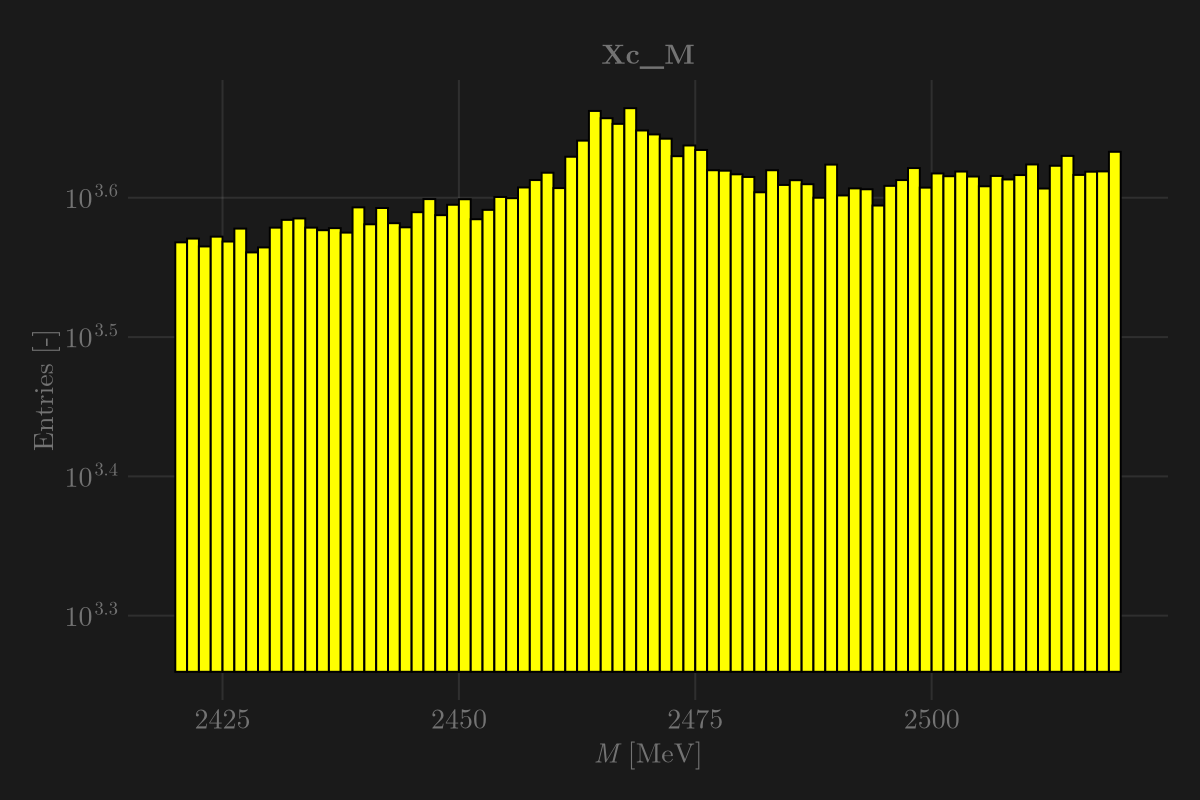

In [23]:
plot_hist(
    df_exp_cut.Xc_M,
    "figures/exp_Xc_M_log10",
    title = "Xc_M",
    xlabel = L"$M$ [MeV]",
    yscale = log10
)

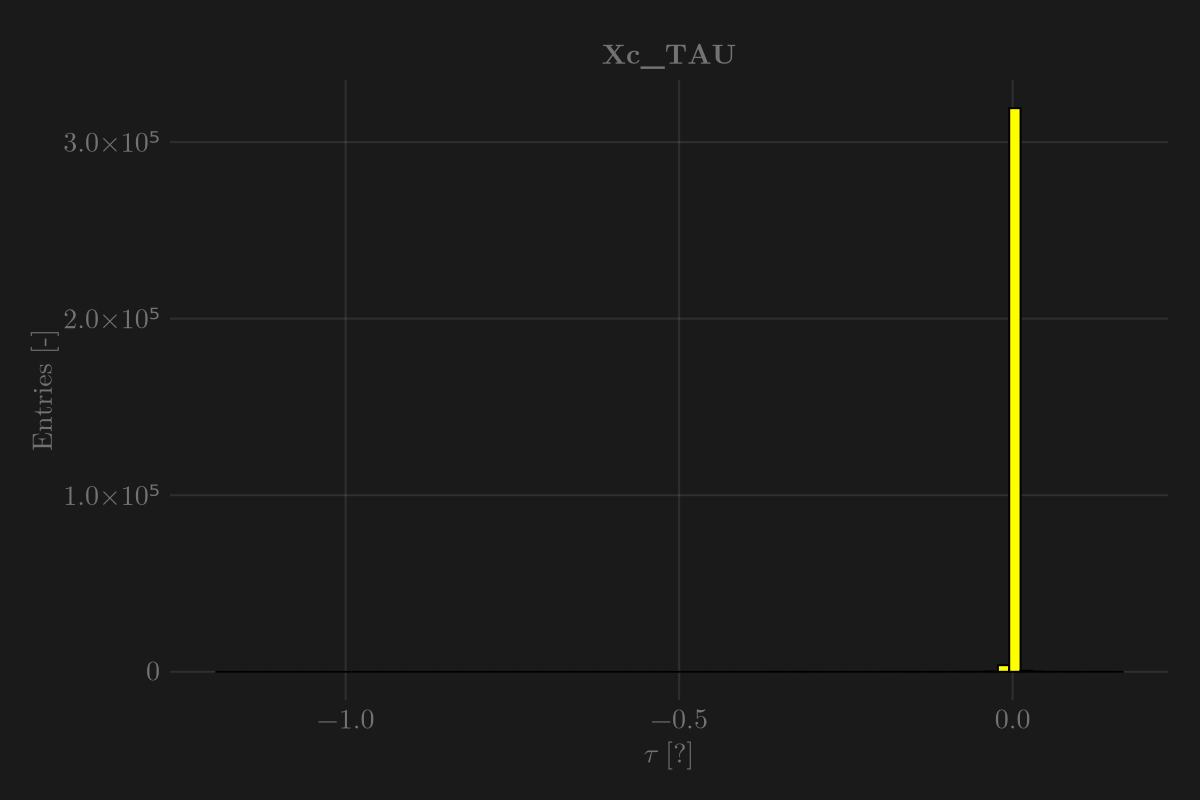

In [24]:
plot_hist(
    df_exp_cut.Xc_TAU,
    "figures/exp_Xc_TAU",
    title = "Xc_TAU",
    xlabel = L"$τ$ [?]"
)

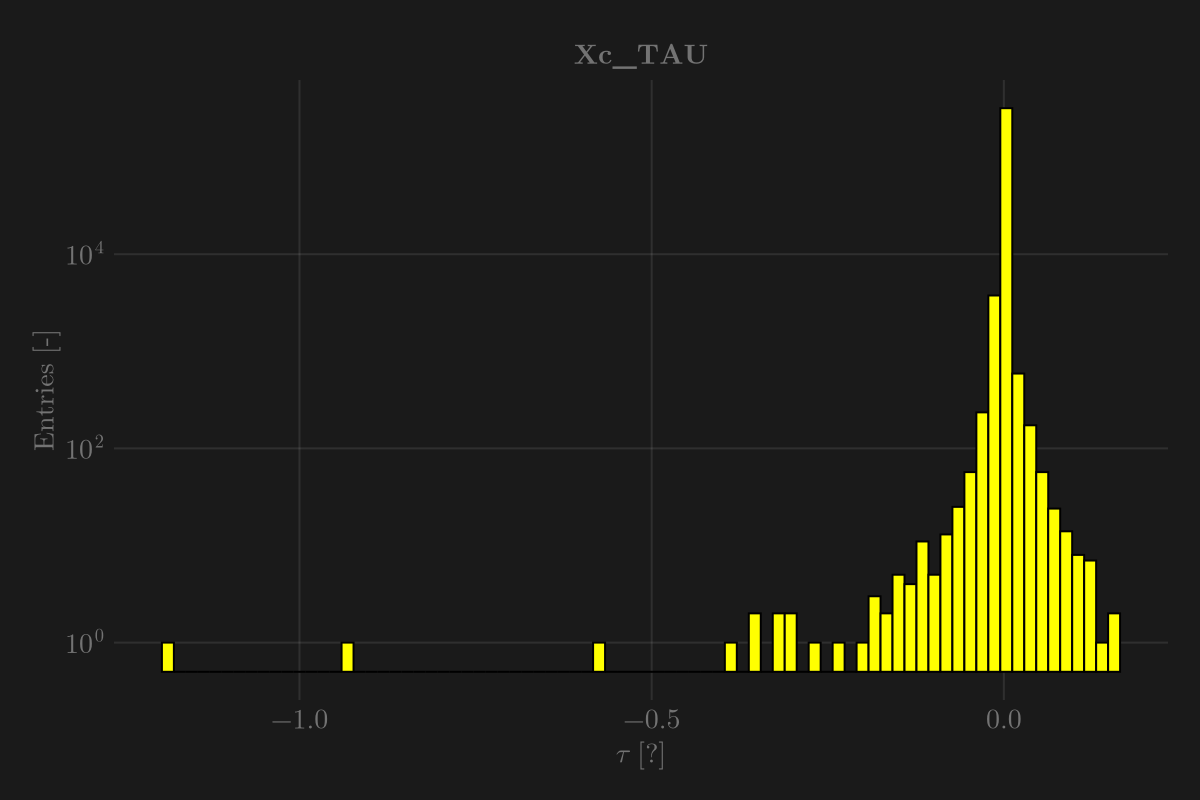

In [25]:
plot_hist(
    df_exp_cut.Xc_TAU,
    "figures/exp_Xc_TAU_log10",
    title = "Xc_TAU",
    xlabel = L"$τ$ [?]",
    yscale = log10
)

I guess we could force more restrictive cuts on Xc_TAU and on Xb_TAU, but the histograms above look _good enough_ in my opinion.